In [1]:
import math
import time

import networkx as nx
import torch
import torch.nn as nn
from net import gtnet
import numpy as np
from util import *

file_path = './model/model-indices.pt'
model = torch.load(file_path)

/tmp/ipykernel_7720/1922443770.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(file_path)


In [2]:
device = 'cuda:0'
data = './data/indices.csv'
horizon = 3
normalize = 2
seq_in_len = 24*7
num_nodes = 11 
subgraph_size = 11 
batch_size = 8
num_split = 3

Data = DataLoaderS(data, 0.6, 0.2, device, horizon, seq_in_len, normalize)
model = model.to(device)

print('The receptive field size is', model.receptive_field)
nParams = sum([p.nelement() for p in model.parameters()])
print('Number of model parameters is', nParams, flush=True)

The receptive field size is 187
Number of model parameters is 337585


In [3]:
evaluateL2 = nn.MSELoss(reduction='sum').to(device)
evaluateL1 = nn.L1Loss(reduction='sum').to(device)

In [4]:
def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval()
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None

    for X, Y in data.get_batches(X, Y, batch_size, False):
        X = torch.unsqueeze(X,dim=1)
        X = X.transpose(2,3)
        with torch.no_grad():
            output = model(X)
        output = torch.squeeze(output)
        if len(output.shape)==1:
            output = output.unsqueeze(dim=0)
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))

        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m)

    rse = math.sqrt(total_loss / n_samples) / data.rse
    rae = (total_loss_l1 / n_samples) / data.rae

    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis=0)
    sigma_g = (Ytest).std(axis=0)
    mean_p = predict.mean(axis=0)
    mean_g = Ytest.mean(axis=0)
    index = (sigma_g != 0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis=0) / (sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    return rse, rae, correlation

In [5]:
test_acc, test_rae, test_corr = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, batch_size)
print("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr), flush=True)

test rse 0.0548 | test rae 0.0461 | test corr 0.8838


In [6]:
A = torch.round(model.gc(model.idx), decimals=4).cpu().detach().numpy()
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
mapping = {0: "Italy", 1: "Turkiye", 2: "France", 3: "UK", 4: "Germany", 5: "US", 6: "Canada", 7: "Indonesia", 8: "Mexico", 9: "Japan", 10: "Nigeria"}
H = nx.relabel_nodes(G, mapping)

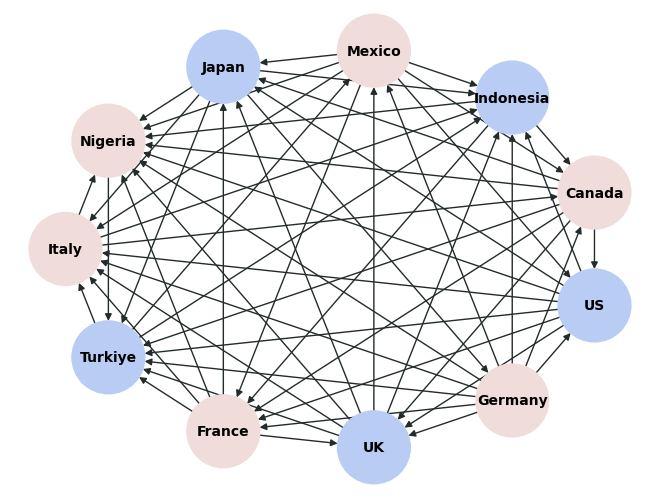

In [36]:
# https://www.color-hex.com/

nx.draw(H, with_labels=True, node_size=2750, font_size=10, font_color='black', font_weight='bold', font_family='sans-serif', node_color=['#f0dcdb', '#b9ccf3','#f0dcdb', '#b9ccf3','#f0dcdb', '#b9ccf3','#f0dcdb', '#b9ccf3','#f0dcdb', '#b9ccf3','#f0dcdb'], edge_color='#232b2b', alpha=1.0, pos=nx.shell_layout(H))